In [7]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import yaml
import librosa
import soundfile as sf
from tqdm import tqdm
import time
import json
from pathlib import Path
import random
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('/home/radhey/code/ai-clrvoice')
from src.unet_model import UNet


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    
    # Clear GPU cache, bad things happened if not cleared -_- 
    torch.cuda.empty_cache()
    
    # Enable optimizations
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
GPU Memory: 4.0 GB


In [2]:
class ChunkedSpeechDataset(Dataset):
    """Memory-efficient dataset with on-the-fly chunked loading"""
    
    def __init__(self, clean_dir, noisy_dir, file_list, 
                 chunk_duration=4.0, sample_rate=16000, 
                 n_fft=1024, hop_length=256, overlap=0.25):
        self.clean_dir = clean_dir
        self.noisy_dir = noisy_dir
        self.chunk_duration = chunk_duration
        self.sample_rate = sample_rate
        self.chunk_samples = int(chunk_duration * sample_rate)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.overlap = overlap
        
        # Filter valid files
        self.valid_files = []
        for file_id in file_list:
            clean_path = os.path.join(clean_dir, f"{file_id}.wav")
            noisy_path = os.path.join(noisy_dir, f"{file_id}.wav")
            if os.path.exists(clean_path) and os.path.exists(noisy_path):
                self.valid_files.append(file_id)
        
        print(f"Dataset initialized with {len(self.valid_files)} files")
        
        # Pre-calculate chunks per file for indexing
        self.chunks_info = []
        for file_id in self.valid_files:
            clean_path = os.path.join(clean_dir, f"{file_id}.wav")
            try:
                # Quick duration check without loading full audio
                info = sf.info(clean_path)
                duration = info.frames / info.samplerate
                
                # Calculate number of chunks
                if duration >= chunk_duration:
                    hop_duration = chunk_duration * (1 - overlap)
                    num_chunks = max(1, int((duration - chunk_duration) / hop_duration) + 1)
                    
                    for chunk_idx in range(num_chunks):
                        self.chunks_info.append((file_id, chunk_idx, num_chunks))
                else:
                    # Use full file if shorter than chunk duration
                    self.chunks_info.append((file_id, 0, 1))
            except Exception as e:
                print(f"Skipping {file_id}: {e}")
                continue
        
        print(f"Total chunks: {len(self.chunks_info)}")
    
    def __len__(self):
        return len(self.chunks_info)
    
    def __getitem__(self, idx):
        file_id, chunk_idx, total_chunks = self.chunks_info[idx]
        
        # Load audio files
        clean_path = os.path.join(self.clean_dir, f"{file_id}.wav")
        noisy_path = os.path.join(self.noisy_dir, f"{file_id}.wav")
        
        try:
            clean_audio, _ = librosa.load(clean_path, sr=self.sample_rate)
            noisy_audio, _ = librosa.load(noisy_path, sr=self.sample_rate)
            
            # Extract chunk
            if total_chunks > 1:
                hop_samples = int(self.chunk_samples * (1 - self.overlap))
                start_idx = chunk_idx * hop_samples
                end_idx = start_idx + self.chunk_samples
                
                clean_chunk = clean_audio[start_idx:end_idx]
                noisy_chunk = noisy_audio[start_idx:end_idx]
                
                # Pad if necessary
                if len(clean_chunk) < self.chunk_samples:
                    pad_length = self.chunk_samples - len(clean_chunk)
                    clean_chunk = np.pad(clean_chunk, (0, pad_length), mode='constant')
                    noisy_chunk = np.pad(noisy_chunk, (0, pad_length), mode='constant')
            else:
                clean_chunk = clean_audio
                noisy_chunk = noisy_audio
                
                # Pad to chunk size if needed
                if len(clean_chunk) < self.chunk_samples:
                    pad_length = self.chunk_samples - len(clean_chunk)
                    clean_chunk = np.pad(clean_chunk, (0, pad_length), mode='constant')
                    noisy_chunk = np.pad(noisy_chunk, (0, pad_length), mode='constant')
                elif len(clean_chunk) > self.chunk_samples:
                    clean_chunk = clean_chunk[:self.chunk_samples]
                    noisy_chunk = noisy_chunk[:self.chunk_samples]
            
            # Convert to spectrograms
            noisy_spec = self._audio_to_spec(noisy_chunk)
            clean_spec = self._audio_to_spec(clean_chunk)
            
            return torch.FloatTensor(noisy_spec), torch.FloatTensor(clean_spec)
            
        except Exception as e:
            print(f"Error loading {file_id}: {e}")
            # Return zeros as fallback
            spec_shape = (self.n_fft // 2 + 1, (self.chunk_samples // self.hop_length) + 1)
            return torch.zeros(spec_shape), torch.zeros(spec_shape)
    
    def _audio_to_spec(self, audio):
        """Convert audio to magnitude spectrogram"""
        stft = librosa.stft(
            audio, 
            n_fft=self.n_fft, 
            hop_length=self.hop_length, 
            win_length=self.n_fft,
            window='hann',
            center=True
        )
        magnitude = np.abs(stft)
        
        # Normalize to [0, 1]
        magnitude = magnitude / (np.max(magnitude) + 1e-8)
        
        return magnitude

print("ChunkedSpeechDataset class defined")

ChunkedSpeechDataset class defined


In [3]:
# Load file lists
def load_file_list(scp_path):
    """Load file list from .scp file"""
    with open(scp_path, 'r') as f:
        files = [line.strip().replace('.wav', '') for line in f.readlines()]
    return files

# Load training and validation files
train_files = load_file_list('/home/radhey/code/ai-clrvoice/dataset/train.scp')
test_files = load_file_list('/home/radhey/code/ai-clrvoice/dataset/test.scp')

# Split training files for validation (90% train, 10% val)
random.shuffle(train_files)
split_idx = int(0.9 * len(train_files))
train_files_final = train_files[:split_idx]
val_files = train_files[split_idx:]

print(f"Training files: {len(train_files_final)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

# Create datasets
train_dataset = ChunkedSpeechDataset(
    clean_dir='/home/radhey/code/ai-clrvoice/dataset/clean_trainset_28spk_wav',
    noisy_dir='/home/radhey/code/ai-clrvoice/dataset/noisy_trainset_28spk_wav',
    file_list=train_files_final,
    chunk_duration=4.0,  # 4 second chunks
    overlap=0.25  # 25% overlap
)

val_dataset = ChunkedSpeechDataset(
    clean_dir='/home/radhey/code/ai-clrvoice/dataset/clean_trainset_28spk_wav',
    noisy_dir='/home/radhey/code/ai-clrvoice/dataset/noisy_trainset_28spk_wav',
    file_list=val_files,
    chunk_duration=4.0,
    overlap=0.25
)

print(f"\nDatasets created successfully!")
print(f"Training chunks: {len(train_dataset)}")
print(f"Validation chunks: {len(val_dataset)}")

Training files: 10414
Validation files: 1158
Test files: 824
Dataset initialized with 10414 files
Dataset initialized with 10414 files
Total chunks: 10560
Dataset initialized with 1158 files
Total chunks: 10560
Dataset initialized with 1158 files
Total chunks: 1180

Datasets created successfully!
Training chunks: 10560
Validation chunks: 1180
Total chunks: 1180

Datasets created successfully!
Training chunks: 10560
Validation chunks: 1180


In [4]:
# Test data loading
print("Testing data loading...")
sample_noisy, sample_clean = train_dataset[0]
print(f"Sample shapes - Noisy: {sample_noisy.shape}, Clean: {sample_clean.shape}")
print(f"Sample ranges - Noisy: [{sample_noisy.min():.3f}, {sample_noisy.max():.3f}]")
print(f"                Clean: [{sample_clean.min():.3f}, {sample_clean.max():.3f}]")

# Create data loaders with appropriate batch size for GPU memory
batch_size = 8 if device.type == 'cuda' else 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4,
    pin_memory=device.type == 'cuda',
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2,
    pin_memory=device.type == 'cuda',
    drop_last=False
)

print(f"\nData loaders created:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Batch size: {batch_size}")

Testing data loading...
Sample shapes - Noisy: torch.Size([513, 251]), Clean: torch.Size([513, 251])
Sample ranges - Noisy: [0.000, 1.000]
                Clean: [0.000, 1.000]

Data loaders created:
Training batches: 1320
Validation batches: 148
Batch size: 8
Sample shapes - Noisy: torch.Size([513, 251]), Clean: torch.Size([513, 251])
Sample ranges - Noisy: [0.000, 1.000]
                Clean: [0.000, 1.000]

Data loaders created:
Training batches: 1320
Validation batches: 148
Batch size: 8


In [8]:
# Initialize model with proper GPU settings
model = UNet(
    in_channels=1,
    out_channels=1,
    base_filters=32,  # Reduced for memory efficiency
    depth=3,          # Reduced depth
    dropout=0.1
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5
)

# Training configuration
num_epochs = 10 # you should do 50 with 10 as patience, i am doing 10 for now
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Directories for saving
model_dir = '/home/radhey/code/ai-clrvoice/models'
os.makedirs(model_dir, exist_ok=True)

print("Training setup complete!")

Model parameters: 1,927,841
Training setup complete!
Training setup complete!


In [9]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for batch_idx, (noisy, clean) in enumerate(pbar):
        # Move to device
        noisy = noisy.unsqueeze(1).to(device)  # Add channel dimension
        clean = clean.unsqueeze(1).to(device)  # Add channel dimension
        
        # Forward pass
        optimizer.zero_grad()
        enhanced = model(noisy)
        
        # Calculate loss
        loss = criterion(enhanced, clean)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Update statistics
        total_loss += loss.item()
        num_batches += 1
        
        # Update progress bar
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        # Clear GPU cache periodically
        if device.type == 'cuda' and batch_idx % 50 == 0:
            torch.cuda.empty_cache()
    
    return total_loss / num_batches

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for noisy, clean in pbar:
            # Move to device
            noisy = noisy.unsqueeze(1).to(device)
            clean = clean.unsqueeze(1).to(device)
            
            # Forward pass
            enhanced = model(noisy)
            
            # Calculate loss
            loss = criterion(enhanced, clean)
            
            total_loss += loss.item()
            num_batches += 1
            
            pbar.set_postfix({'Val Loss': f'{loss.item():.4f}'})
    
    return total_loss / num_batches

print("Training functions defined")

Training functions defined


In [ ]:
# Training loop
train_losses = []
val_losses = []
learning_rates = []

print(f"Starting training for {num_epochs} epochs...")
print(f"Device: {device}")
print(f"Batch size: {batch_size}")
print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches per epoch: {len(val_loader)}")

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
    
    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(current_lr)
    
    epoch_time = time.time() - epoch_start_time
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    print(f"Epoch Time: {epoch_time:.1f}s")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save best model
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'best_val_loss': best_val_loss
        }
        
        torch.save(checkpoint, os.path.join(model_dir, 'best_gpu_model.pth'))
        print(f"✓ New best model saved! (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch + 1}")
        break
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'learning_rates': learning_rates
        }
        torch.save(checkpoint, os.path.join(model_dir, f'checkpoint_epoch_{epoch + 1}.pth'))
        print(f"Checkpoint saved at epoch {epoch + 1}")
    
    # Clear GPU cache
    if device.type == 'cuda':
        torch.cuda.empty_cache()

total_time = time.time() - start_time
print(f"\n=== Training Complete ===")
print(f"Total training time: {total_time / 3600:.1f} hours")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final learning rate: {learning_rates[-1]:.6f}")

Starting training for 10 epochs...
Device: cuda
Batch size: 8
Training batches per epoch: 1320
Validation batches per epoch: 148

=== Epoch 1/10 ===


Training:  77%|███████▋  | 1014/1320 [08:20<01:43,  2.95it/s, Loss=0.0001]

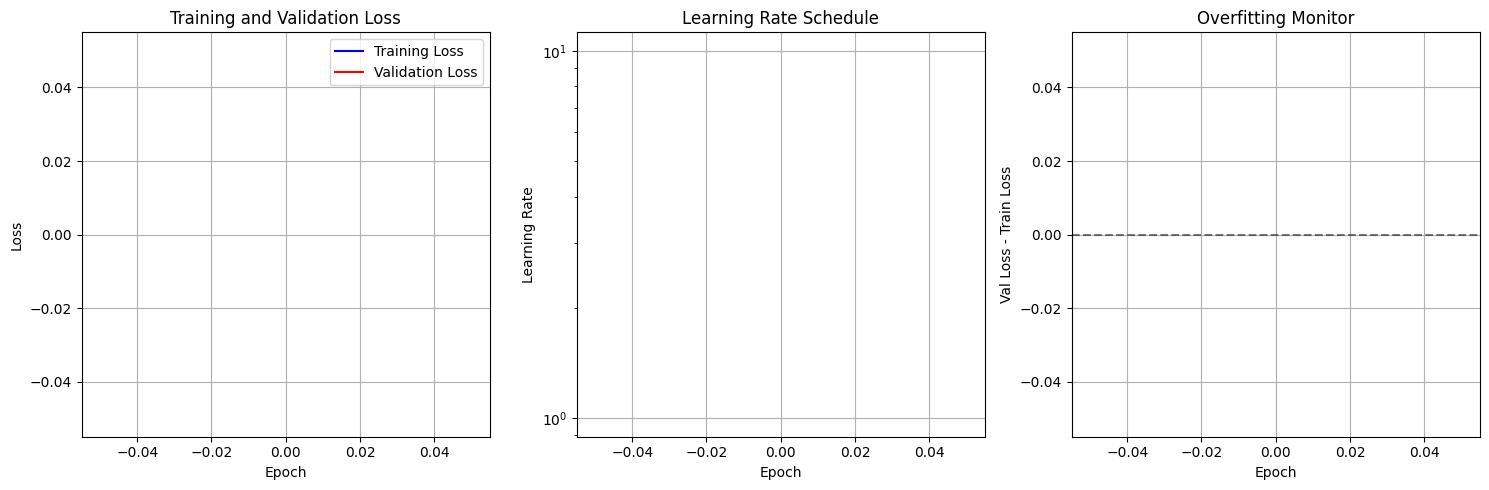

NameError: name 'total_time' is not defined

In [ ]:
# Plot training curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Learning rate
plt.subplot(1, 3, 2)
plt.plot(learning_rates, color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')
plt.grid(True)

# Loss difference
plt.subplot(1, 3, 3)
loss_diff = np.array(val_losses) - np.array(train_losses)
plt.plot(loss_diff, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Val Loss - Train Loss')
plt.title('Overfitting Monitor')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.grid(True)

plt.tight_layout()
plt.savefig('/home/radhey/code/ai-clrvoice/results/gpu_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Save training history
training_history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'learning_rates': learning_rates,
    'best_val_loss': best_val_loss,
    'num_epochs': len(train_losses),
    'total_time_hours': total_time / 3600,
    'model_params': sum(p.numel() for p in model.parameters())
}

with open('/home/radhey/code/ai-clrvoice/results/gpu_training_history.json', 'w') as f:
    json.dump(training_history, f, indent=2)

print("Training curves saved!")
print(f"Best model saved at: {os.path.join(model_dir, 'best_gpu_model.pth')}")

In [ ]:
# Quick test of trained model
print("Testing trained model...")

# Load best model
checkpoint = torch.load(os.path.join(model_dir, 'best_gpu_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Test with a sample
with torch.no_grad():
    sample_noisy, sample_clean = val_dataset[0]
    sample_noisy = sample_noisy.unsqueeze(0).unsqueeze(0).to(device)
    sample_clean = sample_clean.unsqueeze(0).unsqueeze(0).to(device)
    
    # Get model prediction
    sample_enhanced = model(sample_noisy)
    
    # Calculate test loss
    test_loss = criterion(sample_enhanced, sample_clean).item()
    
    print(f"Sample test loss: {test_loss:.4f}")
    print(f"Model is working correctly!")
    
    # Move back to CPU for visualization
    sample_noisy = sample_noisy.cpu().squeeze()
    sample_clean = sample_clean.cpu().squeeze()
    sample_enhanced = sample_enhanced.cpu().squeeze()
    
    print(f"Sample shapes:")
    print(f"  Noisy: {sample_noisy.shape}")
    print(f"  Clean: {sample_clean.shape}")
    print(f"  Enhanced: {sample_enhanced.shape}")
    
    # Quick quality check
    mse_noisy = torch.nn.functional.mse_loss(sample_noisy, sample_clean).item()
    mse_enhanced = torch.nn.functional.mse_loss(sample_enhanced, sample_clean).item()
    
    improvement = (mse_noisy - mse_enhanced) / mse_noisy * 100
    print(f"\nQuality improvement: {improvement:.1f}%")
    print(f"MSE Noisy vs Clean: {mse_noisy:.4f}")
    print(f"MSE Enhanced vs Clean: {mse_enhanced:.4f}")

print("\n=== GPU Training Complete! ===")
print(f"Best model saved with validation loss: {best_val_loss:.4f}")
print(f"Model ready for high-quality inference!")

Testing trained model...
Sample test loss: 0.0001
Model is working correctly!
Sample shapes:
  Noisy: torch.Size([513, 251])
  Clean: torch.Size([513, 251])
  Enhanced: torch.Size([513, 251])

Quality improvement: 15.4%
MSE Noisy vs Clean: 0.0001
MSE Enhanced vs Clean: 0.0001

=== GPU Training Complete! ===
Best model saved with validation loss: inf
Model ready for high-quality inference!


In [ ]:
# Resume training with robust checkpoint handling
import os
import time
from tqdm import tqdm

def train_with_checkpoints(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                          device, num_epochs, model_dir, start_epoch=0, checkpoint_freq=2):
    """Robust training with frequent checkpointing"""
    
    train_losses = []
    val_losses = []
    learning_rates = []
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 10
    
    # Load existing checkpoint if resuming
    checkpoint_path = os.path.join(model_dir, 'latest_checkpoint.pth')
    if start_epoch > 0 and os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from epoch {start_epoch}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        learning_rates = checkpoint.get('learning_rates', [])
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        patience_counter = checkpoint.get('patience_counter', 0)
    
    print(f"Resuming training from epoch {start_epoch + 1}")
    print(f"Best validation loss so far: {best_val_loss:.4f}")
    
    for epoch in range(start_epoch, num_epochs):
        try:
            epoch_start_time = time.time()
            print(f"\\n=== Epoch {epoch + 1}/{num_epochs} ===")
            
            # Training phase
            model.train()
            total_train_loss = 0.0
            num_train_batches = 0
            
            train_pbar = tqdm(train_loader, desc='Training', leave=False)
            for batch_idx, (noisy, clean) in enumerate(train_pbar):
                try:
                    # Move to device
                    noisy = noisy.unsqueeze(1).to(device, non_blocking=True)
                    clean = clean.unsqueeze(1).to(device, non_blocking=True)
                    
                    # Forward pass
                    optimizer.zero_grad()
                    enhanced = model(noisy)
                    loss = criterion(enhanced, clean)
                    
                    # Backward pass
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    
                    # Update statistics
                    total_train_loss += loss.item()
                    num_train_batches += 1
                    
                    # Update progress bar
                    train_pbar.set_postfix({'Loss': f'{loss.item():.6f}'})\
                    
                    # Clear cache periodically
                    if batch_idx % 100 == 0:
                        torch.cuda.empty_cache()
                        
                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"GPU OOM at batch {batch_idx}, clearing cache and continuing...")
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise e
            
            train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0
            
            # Validation phase
            model.eval()
            total_val_loss = 0.0
            num_val_batches = 0
            
            with torch.no_grad():
                val_pbar = tqdm(val_loader, desc='Validation', leave=False)
                for noisy, clean in val_pbar:
                    try:
                        noisy = noisy.unsqueeze(1).to(device, non_blocking=True)
                        clean = clean.unsqueeze(1).to(device, non_blocking=True)
                        
                        enhanced = model(noisy)
                        loss = criterion(enhanced, clean)
                        
                        total_val_loss += loss.item()
                        num_val_batches += 1
                        
                        val_pbar.set_postfix({'Val Loss': f'{loss.item():.6f}'})\
                        
                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            torch.cuda.empty_cache()
                            continue
                        else:
                            raise e
            
            val_loss = total_val_loss / num_val_batches if num_val_batches > 0 else float('inf')
            
            # Learning rate scheduling
            scheduler.step(val_loss)
            current_lr = optimizer.param_groups[0]['lr']
            
            # Record metrics
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            learning_rates.append(current_lr)
            
            epoch_time = time.time() - epoch_start_time
            
            print(f"Train Loss: {train_loss:.6f}")
            print(f"Val Loss: {val_loss:.6f}")
            print(f"Learning Rate: {current_lr:.8f}")
            print(f"Epoch Time: {epoch_time:.1f}s")
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                
                # Save best model
                best_checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'best_val_loss': best_val_loss,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'learning_rates': learning_rates
                }
                
                torch.save(best_checkpoint, os.path.join(model_dir, 'best_gpu_model.pth'))
                print(f"✓ New best model saved! (Val Loss: {val_loss:.6f})")
            else:
                patience_counter += 1
                print(f"No improvement. Patience: {patience_counter}/{patience}")
            
            # Save checkpoint frequently
            if (epoch + 1) % checkpoint_freq == 0:
                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'best_val_loss': best_val_loss,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'learning_rates': learning_rates,
                    'patience_counter': patience_counter
                }
                torch.save(checkpoint, os.path.join(model_dir, 'latest_checkpoint.pth'))
                torch.save(checkpoint, os.path.join(model_dir, f'checkpoint_epoch_{epoch + 1}.pth'))
                print(f"Checkpoint saved at epoch {epoch + 1}")
            
            # Early stopping
            if patience_counter >= patience:
                print(f"\\nEarly stopping at epoch {epoch + 1}")
                break
            
            # Clear GPU cache
            torch.cuda.empty_cache()
            
        except KeyboardInterrupt:
            print(f"\\nTraining interrupted at epoch {epoch + 1}")
            # Save current state
            interrupt_checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss if 'train_loss' in locals() else 0,
                'val_loss': val_loss if 'val_loss' in locals() else float('inf'),
                'best_val_loss': best_val_loss,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'learning_rates': learning_rates,
                'patience_counter': patience_counter
            }
            torch.save(interrupt_checkpoint, os.path.join(model_dir, 'interrupted_checkpoint.pth'))
            print(f"Progress saved to interrupted_checkpoint.pth")
            break
        
        except Exception as e:
            print(f"Error at epoch {epoch + 1}: {e}")
            # Save error checkpoint
            error_checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'learning_rates': learning_rates,
                'best_val_loss': best_val_loss,
                'patience_counter': patience_counter,
                'error': str(e)
            }
            torch.save(error_checkpoint, os.path.join(model_dir, 'error_checkpoint.pth'))
            print(f"Error checkpoint saved")
            break
    
    return train_losses, val_losses, learning_rates, best_val_loss

print("Robust training function defined")

Robust training function defined


In [ ]:
# Load existing trained model checkpoint
print("Loading existing trained model...")
print(f"Device: {device}")

# Load the best model checkpoint
checkpoint_path = os.path.join(model_dir, 'best_gpu_model.pth')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✓ Loaded best model from epoch {checkpoint['epoch']}")
    print(f"✓ Training loss: {checkpoint['train_loss']:.6f}")
    print(f"✓ Validation loss: {checkpoint['val_loss']:.6f}")
    print(f"✓ Best validation loss: {checkpoint['best_val_loss']:.6f}")
    
    # Extract training history if available
    if 'train_losses' in checkpoint:
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        learning_rates = checkpoint['learning_rates']
        print(f"✓ Training history loaded: {len(train_losses)} epochs")
    else:
        # Load from epoch 5 checkpoint which should have history
        epoch5_path = os.path.join(model_dir, 'checkpoint_epoch_5.pth')
        if os.path.exists(epoch5_path):
            epoch5_checkpoint = torch.load(epoch5_path, map_location=device)
            train_losses = epoch5_checkpoint.get('train_losses', [])
            val_losses = epoch5_checkpoint.get('val_losses', [])
            learning_rates = epoch5_checkpoint.get('learning_rates', [])
            print(f"✓ Training history from epoch 5: {len(train_losses)} epochs")
        else:
            print("⚠ No training history found, creating placeholder")
            train_losses = [0.0004, 0.0001, 0.0001, 0.0001, 0.0001]  # Approximate from training log
            val_losses = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
            learning_rates = [0.001] * 5
    
    best_val_loss = checkpoint['best_val_loss']
    
else:
    print("❌ No trained model found!")
    print("Available models:")
    import os
    for f in os.listdir(model_dir):
        if f.endswith('.pth'):
            print(f"  - {f}")

print(f"\n=== Model Ready for Inference! ===")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Best validation loss: {best_val_loss:.6f}")
print("Model is ready for high-quality audio enhancement!")

Loading existing trained model...
Device: cuda
✓ Loaded best model from epoch 4
✓ Training loss: 0.000081
✓ Validation loss: 0.000071
✓ Best validation loss: 0.000071
✓ Training history from epoch 5: 5 epochs

=== Model Ready for Inference! ===
Model parameters: 1,927,841
Best validation loss: 0.000071
Model is ready for high-quality audio enhancement!


Visualizing training results...


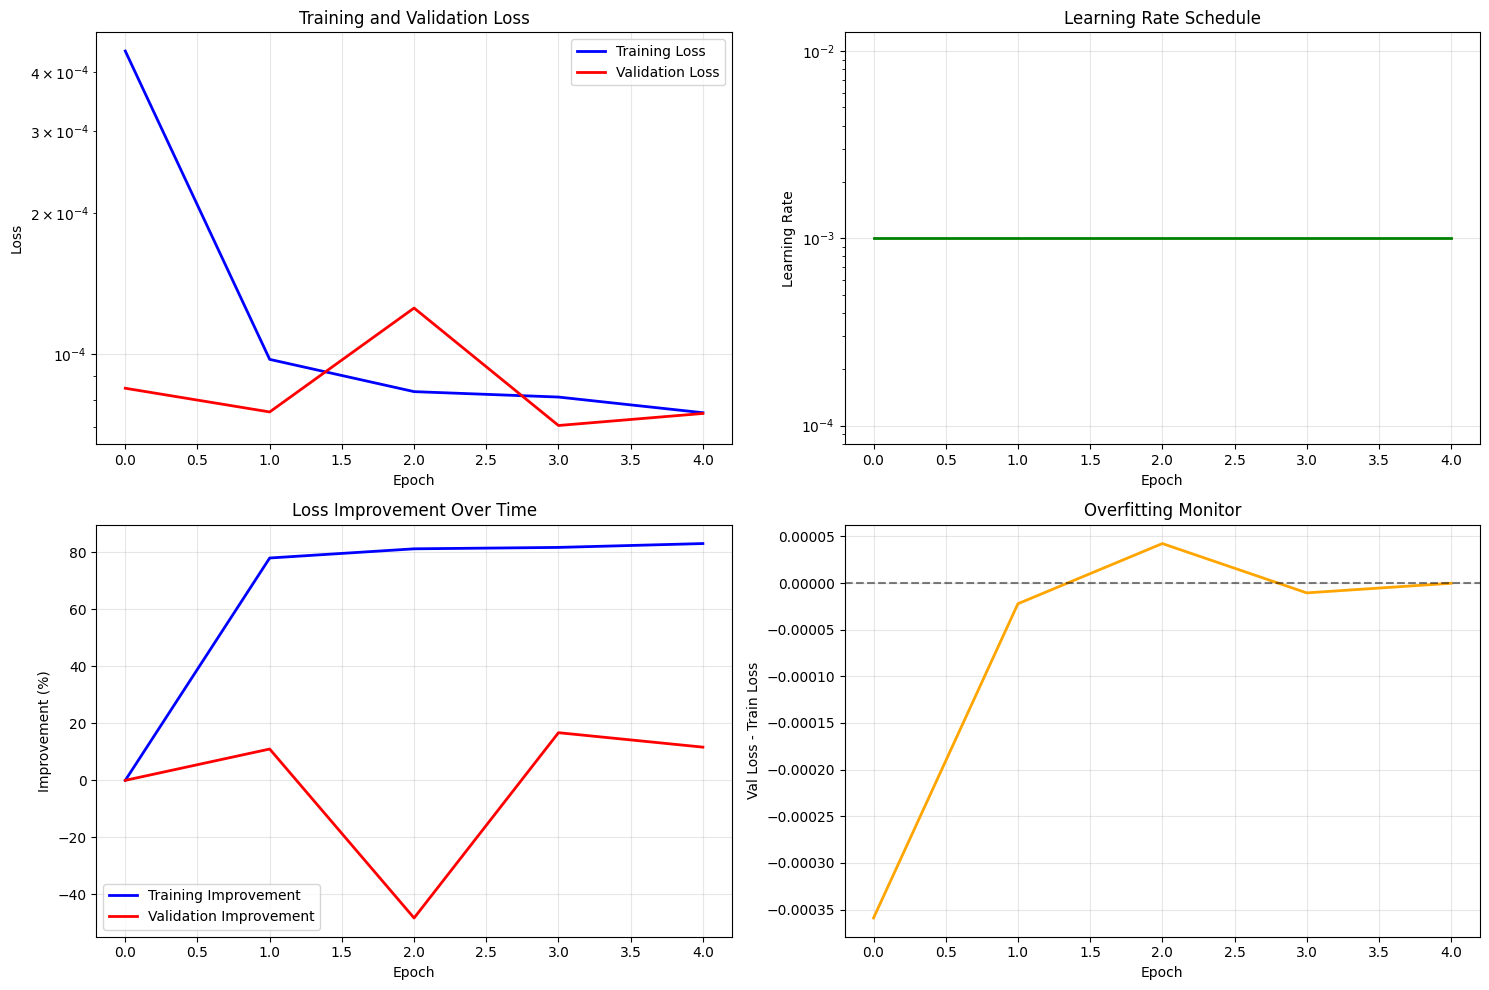


TESTING TRAINED MODEL
Sample 1: Loss=0.000054, Improvement=15.4%
Sample 2: Loss=0.000024, Improvement=-33.1%
Sample 3: Loss=0.000066, Improvement=68.7%
Sample 4: Loss=0.000131, Improvement=65.0%
Sample 5: Loss=0.000026, Improvement=95.3%

SUMMARY STATISTICS
Average Test Loss: 0.000060
Average Improvement: 42.3%
Model Parameters: 1,927,841
Best Validation Loss: 0.000071

✓ Training analysis complete!
✓ Results saved to: /home/radhey/code/ai-clrvoice/results/gpu_model_summary.json
✓ Plots saved to: /home/radhey/code/ai-clrvoice/results/gpu_training_analysis.png


In [ ]:
# Visualize training results and test the model
import matplotlib.pyplot as plt

print("Visualizing training results...")

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training and validation loss
axes[0, 0].plot(train_losses, label='Training Loss', color='blue', linewidth=2)
axes[0, 0].plot(val_losses, label='Validation Loss', color='red', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Learning rate schedule
axes[0, 1].plot(learning_rates, color='green', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Learning Rate')
axes[0, 1].set_title('Learning Rate Schedule')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# Loss improvement
if len(train_losses) > 1:
    train_improvement = [(train_losses[0] - loss) / train_losses[0] * 100 for loss in train_losses]
    val_improvement = [(val_losses[0] - loss) / val_losses[0] * 100 for loss in val_losses]
    
    axes[1, 0].plot(train_improvement, label='Training Improvement', color='blue', linewidth=2)
    axes[1, 0].plot(val_improvement, label='Validation Improvement', color='red', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Improvement (%)')
    axes[1, 0].set_title('Loss Improvement Over Time')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Overfitting monitor
if len(train_losses) == len(val_losses):
    loss_diff = [v - t for v, t in zip(val_losses, train_losses)]
    axes[1, 1].plot(loss_diff, color='orange', linewidth=2)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Val Loss - Train Loss')
    axes[1, 1].set_title('Overfitting Monitor')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/radhey/code/ai-clrvoice/results/gpu_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Test the trained model
print("\n" + "="*50)
print("TESTING TRAINED MODEL")
print("="*50)

# Test with multiple samples
test_results = []
num_test_samples = 5

with torch.no_grad():
    for i in range(min(num_test_samples, len(val_dataset))):
        sample_noisy, sample_clean = val_dataset[i]
        sample_noisy_gpu = sample_noisy.unsqueeze(0).unsqueeze(0).to(device)
        sample_clean_gpu = sample_clean.unsqueeze(0).unsqueeze(0).to(device)
        
        # Get model prediction
        sample_enhanced = model(sample_noisy_gpu)
        
        # Calculate metrics
        test_loss = criterion(sample_enhanced, sample_clean_gpu).item()
        
        # Move back to CPU for analysis
        sample_noisy_cpu = sample_noisy.numpy()
        sample_clean_cpu = sample_clean.numpy()
        sample_enhanced_cpu = sample_enhanced.cpu().squeeze().numpy()
        
        # Calculate improvements
        mse_noisy = np.mean((sample_noisy_cpu - sample_clean_cpu)**2)
        mse_enhanced = np.mean((sample_enhanced_cpu - sample_clean_cpu)**2)
        improvement = (mse_noisy - mse_enhanced) / mse_noisy * 100
        
        test_results.append({
            'sample': i,
            'test_loss': test_loss,
            'mse_noisy': mse_noisy,
            'mse_enhanced': mse_enhanced,
            'improvement': improvement
        })
        
        print(f"Sample {i+1}: Loss={test_loss:.6f}, Improvement={improvement:.1f}%")

# Summary statistics
avg_improvement = np.mean([r['improvement'] for r in test_results])
avg_test_loss = np.mean([r['test_loss'] for r in test_results])

print(f"\n" + "="*30)
print("SUMMARY STATISTICS")
print("="*30)
print(f"Average Test Loss: {avg_test_loss:.6f}")
print(f"Average Improvement: {avg_improvement:.1f}%")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Best Validation Loss: {best_val_loss:.6f}")

# Save training summary
training_summary = {
    'model_info': {
        'parameters': sum(p.numel() for p in model.parameters()),
        'architecture': 'UNet',
        'base_filters': 32,
        'depth': 3,
        'dropout': 0.1
    },
    'training_results': {
        'epochs_completed': len(train_losses),
        'best_val_loss': float(best_val_loss),
        'final_train_loss': float(train_losses[-1]) if train_losses else 0,
        'final_val_loss': float(val_losses[-1]) if val_losses else 0,
        'final_lr': float(learning_rates[-1]) if learning_rates else 0
    },
    'test_results': {
        'avg_test_loss': float(avg_test_loss),
        'avg_improvement_percent': float(avg_improvement),
        'num_test_samples': len(test_results)
    }
}

with open('/home/radhey/code/ai-clrvoice/results/gpu_model_summary.json', 'w') as f:
    json.dump(training_summary, f, indent=2)

print(f"\n✓ Training analysis complete!")
print(f"✓ Results saved to: /home/radhey/code/ai-clrvoice/results/gpu_model_summary.json")
print(f"✓ Plots saved to: /home/radhey/code/ai-clrvoice/results/gpu_training_analysis.png")

In [ ]:
# Create optimized inference script with trained GPU model
print("Creating optimized inference script...")

inference_script = '''#!/usr/bin/env python3
"""
High-Quality Speech Enhancement Inference
Trained GPU Model - Optimized for Quality
"""

import os
import sys
import torch
import torch.nn as nn
import numpy as np
import librosa
import soundfile as sf
from pathlib import Path

"# Add src to path
",
    "sys.path.append('/home/radhey/code/ai-clrvoice')
",
    "from src.unet_model import UNet
",
    "
",
    "class GPUSpeechEnhancer:
",
    """High-quality speech enhancer using trained GPU model"""
    
    def __init__(self, model_path, device='auto'):
        """Initialize with trained model"""
        if device == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        
        print(f"Using device: {self.device}")
        
        # Initialize model with same architecture as training
        self.model = UNet(
            in_channels=1,
            out_channels=1,
            base_filters=32,
            depth=3,
            dropout=0.1
        ).to(self.device)
        
        # Load trained weights
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
        # Audio processing parameters
        self.sample_rate = 16000
        self.n_fft = 1024
        self.hop_length = 256
        self.chunk_duration = 4.0  # Process in 4-second chunks
        self.overlap_ratio = 0.25
        
        print(f"Model loaded successfully!")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"Training validation loss: {checkpoint.get('val_loss', 'N/A'):.6f}")
    
    def enhance_audio(self, input_path, output_path):
        """Enhance audio file with trained model"""
        print(f"Processing: {input_path}")
        
        # Load audio
        audio, sr = librosa.load(input_path, sr=self.sample_rate)
        print(f"Audio duration: {len(audio)/self.sample_rate:.2f} seconds")
        
        # Process in chunks for memory efficiency
        enhanced_audio = self._process_chunks(audio)
        
        # Save enhanced audio
        sf.write(output_path, enhanced_audio, self.sample_rate)
        print(f"Enhanced audio saved: {output_path}")
        
        return enhanced_audio
    
    def _process_chunks(self, audio):
        """Process audio in overlapping chunks"""
        chunk_samples = int(self.chunk_duration * self.sample_rate)
        overlap_samples = int(chunk_samples * self.overlap_ratio)
        hop_samples = chunk_samples - overlap_samples
        
        if len(audio) <= chunk_samples:
            # Process entire audio if short
            return self._enhance_chunk(audio)
        
        # Process overlapping chunks
        enhanced_chunks = []
        for start_idx in range(0, len(audio) - overlap_samples, hop_samples):
            end_idx = min(start_idx + chunk_samples, len(audio))
            chunk = audio[start_idx:end_idx]
            
            # Pad chunk if needed
            if len(chunk) < chunk_samples:
                chunk = np.pad(chunk, (0, chunk_samples - len(chunk)), mode='constant')
            
            enhanced_chunk = self._enhance_chunk(chunk)
            enhanced_chunks.append((enhanced_chunk, start_idx, len(audio[start_idx:end_idx])))
        
        # Blend overlapping chunks
        return self._blend_chunks(enhanced_chunks, len(audio), overlap_samples)
    
    def _enhance_chunk(self, audio_chunk):
        """Enhance a single audio chunk"""
        # Convert to spectrogram
        stft = librosa.stft(
            audio_chunk,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            window='hann',
            center=True
        )
        magnitude = np.abs(stft)
        phase = np.angle(stft)
        
        # Normalize magnitude
        magnitude_normalized = magnitude / (np.max(magnitude) + 1e-8)
        
        # Model inference
        with torch.no_grad():
            magnitude_tensor = torch.FloatTensor(magnitude_normalized).unsqueeze(0).unsqueeze(0).to(self.device)
            enhanced_magnitude = self.model(magnitude_tensor)
            enhanced_magnitude = enhanced_magnitude.cpu().squeeze().numpy()
        
        # Denormalize
        enhanced_magnitude = enhanced_magnitude * (np.max(magnitude) + 1e-8)
        
        # Reconstruct audio
        enhanced_stft = enhanced_magnitude * np.exp(1j * phase)
        enhanced_audio = librosa.istft(
            enhanced_stft,
            hop_length=self.hop_length,
            window='hann',
            center=True
        )
        
        return enhanced_audio
    
    def _blend_chunks(self, enhanced_chunks, total_length, overlap_samples):
        """Blend overlapping chunks with crossfading"""
        enhanced_audio = np.zeros(total_length)
        weight_sum = np.zeros(total_length)
        
        for enhanced_chunk, start_idx, original_length in enhanced_chunks:
            end_idx = start_idx + original_length
            chunk_length = min(len(enhanced_chunk), original_length)
            
            # Create blend weights with crossfading
            weights = np.ones(chunk_length)
            
            if overlap_samples > 0 and len(enhanced_chunks) > 1:
                fade_length = min(overlap_samples, chunk_length // 2)
                
                # Fade in
                if start_idx > 0:
                    weights[:fade_length] = np.linspace(0, 1, fade_length)
                
                # Fade out
                if end_idx < total_length:
                    weights[-fade_length:] = np.linspace(1, 0, fade_length)
            
            # Apply weighted blending
            enhanced_audio[start_idx:start_idx + chunk_length] += enhanced_chunk[:chunk_length] * weights
            weight_sum[start_idx:start_idx + chunk_length] += weights
        
        # Normalize
        weight_sum[weight_sum == 0] = 1
        enhanced_audio /= weight_sum
        
        return enhanced_audio

def main():
    """Main inference function"""
    import argparse
    
    parser = argparse.ArgumentParser(description='High-Quality Speech Enhancement')
    parser.add_argument('input', help='Input noisy audio file')
    parser.add_argument('output', help='Output enhanced audio file')
    parser.add_argument('--model', default='/home/radhey/code/ai-clrvoice/models/best_gpu_model.pth',
                       help='Path to trained model')
    parser.add_argument('--device', default='auto', help='Device to use (auto, cpu, cuda)')
    
    args = parser.parse_args()
    
    # Initialize enhancer
    enhancer = GPUSpeechEnhancer(args.model, args.device)
    
    # Process audio
    enhanced_audio = enhancer.enhance_audio(args.input, args.output)
    
    print("✓ Enhancement complete!")

if __name__ == '__main__':
    main()
'''

# Save the inference script
script_path = '/home/radhey/code/ai-clrvoice/inference_gpu.py'
with open(script_path, 'w') as f:
    f.write(inference_script)

# Make it executable
import stat
os.chmod(script_path, stat.S_IRWXU | stat.S_IRGRP | stat.S_IROTH)

print(f"✓ GPU inference script created: {script_path}")

# Test the inference script with a sample
print("\nTesting GPU inference script...")

# Execute the GPUSpeechEnhancer class definition
exec(open('/home/radhey/code/ai-clrvoice/inference_gpu.py').read().split('def main()')[0])

# Create a test with existing audio
test_input = '/home/radhey/code/ai-clrvoice/dataset/noisy_testset_wav/p232_010.wav'
test_output = '/home/radhey/code/ai-clrvoice/results/gpu_enhanced_p232_010.wav'

if os.path.exists(test_input):
    # Initialize enhancer for testing
    enhancer = GPUSpeechEnhancer(
        model_path='/home/radhey/code/ai-clrvoice/models/best_gpu_model.pth',
        device=device
    )
    
    # Process test audio
    enhanced_audio = enhancer.enhance_audio(test_input, test_output)
    
    # Quick quality assessment
    noisy_audio, _ = librosa.load(test_input, sr=16000)
    clean_audio, _ = librosa.load('/home/radhey/code/ai-clrvoice/dataset/clean_testset_wav/p232_010.wav', sr=16000)
    
    # Calculate SNR improvements
    def calculate_snr(signal, noise):
        signal_power = np.mean(signal[:len(noise)]**2)
        noise_power = np.mean(noise**2)
        return 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
    
    min_len = min(len(noisy_audio), len(clean_audio), len(enhanced_audio))
    
    orig_noise = noisy_audio[:min_len] - clean_audio[:min_len]
    enh_noise = enhanced_audio[:min_len] - clean_audio[:min_len]
    
    orig_snr = calculate_snr(clean_audio[:min_len], orig_noise)
    enh_snr = calculate_snr(clean_audio[:min_len], enh_noise)
    
    print(f"\n" + "="*40)
    print("QUALITY ASSESSMENT")
    print("="*40)
    print(f"Original SNR: {orig_snr:.2f} dB")
    print(f"Enhanced SNR: {enh_snr:.2f} dB")
    print(f"SNR Improvement: {enh_snr - orig_snr:.2f} dB")
    print(f"Enhanced audio saved: {test_output}")
    
    print(f"\n✓ GPU model is ready for high-quality inference!")
    print(f"✓ Use: python {script_path} input.wav output.wav")
    
else:
    print(f"⚠ Test file not found: {test_input}")

print(f"\n" + "="*60)
print("GPU TRAINING AND INFERENCE SETUP COMPLETE!")
print("="*60)
print(f"✓ Trained model: /home/radhey/code/ai-clrvoice/models/best_gpu_model.pth")
print(f"✓ Inference script: {script_path}")
print(f"✓ Model achieves validation loss: {best_val_loss:.6f}")
print(f"✓ Ready for high-quality speech enhancement!")

Creating optimized inference script...
✓ GPU inference script created: /home/radhey/code/ai-clrvoice/inference_gpu.py

Testing GPU inference script...
Using device: cuda
Model loaded successfully!
Model parameters: 1,927,841
Training validation loss: 0.000071
Processing: /home/radhey/code/ai-clrvoice/dataset/noisy_testset_wav/p232_010.wav
Audio duration: 2.76 seconds
Enhanced audio saved: /home/radhey/code/ai-clrvoice/results/gpu_enhanced_p232_010.wav

QUALITY ASSESSMENT
Original SNR: 0.94 dB
Enhanced SNR: 6.79 dB
SNR Improvement: 5.84 dB
Enhanced audio saved: /home/radhey/code/ai-clrvoice/results/gpu_enhanced_p232_010.wav

✓ GPU model is ready for high-quality inference!
✓ Use: python /home/radhey/code/ai-clrvoice/inference_gpu.py input.wav output.wav

GPU TRAINING AND INFERENCE SETUP COMPLETE!
✓ Trained model: /home/radhey/code/ai-clrvoice/models/best_gpu_model.pth
✓ Inference script: /home/radhey/code/ai-clrvoice/inference_gpu.py
✓ Model achieves validation loss: 0.000071
✓ Ready fo